# Assignment 4

In [1]:
import numpy as np 
import pandas as pd 

from matplotlib.pyplot import subplots 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle

from tqdm import tqdm

import warnings

## Deal with data

In [2]:
# Load the dataset
df = pd.read_csv('data/House_price.csv')

X = df.drop('price', axis=1)
y = df.price

# X.info()

In [3]:
# transform YES/FALSE data into binary:
X = pd.get_dummies(X, drop_first=True, dummy_na=True) # drop_first=True to avoid dummy variable trap
# X.info()

In [4]:
# We drop those because they are empty
X.drop('bus_ter_nan', axis=1, inplace=True)
X.drop('airport_nan', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   crime_rate                506 non-null    float64
 1   resid_area                506 non-null    float64
 2   air_qual                  506 non-null    float64
 3   room_num                  506 non-null    float64
 4   age                       506 non-null    float64
 5   dist1                     506 non-null    float64
 6   dist2                     506 non-null    float64
 7   dist3                     506 non-null    float64
 8   dist4                     506 non-null    float64
 9   teachers                  506 non-null    float64
 10  poor_prop                 506 non-null    float64
 11  n_hos_beds                498 non-null    float64
 12  n_hot_rooms               506 non-null    float64
 13  rainfall                  506 non-null    int64  
 14  parks     

In [5]:
proportion_yes_no = X['waterbody_nan'].value_counts(normalize=True)
print(proportion_yes_no)

waterbody_nan
False    0.693676
True     0.306324
Name: proportion, dtype: float64


Interpretation of `waterbody`:
- River, River & Lake, Lake: What's close to the house
- None/missing: There is no River or Lake close to the house

So we'll treat `waterbody_nan` as the binary data that says that there is no River nor Lake close to the house.

## Implement regression tree algorithm from scratch
What I understood from StatQuest:
- Recursive binary splitting: We first take the predicator $X_j$ and the cut point $s$ such that we split the space in two regions ${X|X_j < s}$ and ${X|X_j > s}$ leads to the **greatest possible reduction in RSS**.
- For any $j$ and $s$ we define the pair of half-planes
- So if our data set contains many features $(X_n)_{n \in \mathbb N}$, I think we do some cross validation on all splits ${X|X_j < s}$ and ${X|X_j > s}$ for all $0 \le j \le n$ and then take make a node on the one that split it with the greatest reduction in RSS.

The goal is to find the boxes $R1,\dots,R_J$ that minimze the RSS.

-> **Question**: how do we find the right amount of boxes $J$? 
- We have to put a criteria of minimum data in one box. Usually its around 20 from what I recall from StatQuest

I want to make this tree recursively so I will try my best to create object `TreeNode` and `RegressionTree`.

In [6]:
# Here X and y data are ndarray.

class TreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, ssr=None):
        self.feature_index = feature_index # index of the feature to split on
        self.threshold = threshold # threshold value to split feature on
        self.left = left # left child TreeNode (np array of indexes)
        self.right = right # right child TreeNode (np array of indexes)
        self.value = value # mean of the terminal region (for leaves)
        self.ssr = ssr # sum of squared residuals for this node (mean SSR)

class RegressionTree:
    def __init__(self, min_samples_leaf=2, max_depth=2):
        self.min_samples_leaf = min_samples_leaf # minimum number of samples to be a leaf
        self.max_depth = max_depth
        self.root = None
    
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)


    def predict(self, X):
        """
        Predict the value of a dataset
        ---------------------------------
        self : RegressionTree
        X : ndarray of shape (n_samples, n_features)
        """
        return np.array([self._predict_value(x, self.root) for x in X])
    

    def _compute_ssr(self, y):
        return np.sum((y - y.mean())**2)

    def _find_best_split(self, X, y):
        best_ssr = np.inf
        best_feature = None
        best_threshold = None
        best_left = None
        best_right = None

        # Compute the SSR for the current data
        current_ssr = self._compute_ssr(y)

        for feature_index in range(X.shape[1]):
            # sort the dataset by increasing values of the feature
            sorted_indices = np.argsort(X[:, feature_index])

            # find the number of unique values in this feature
            unique_values = np.unique(X[sorted_indices][:, feature_index])

            # compute adjacent means of unique values
            thresholds = (unique_values[1:] + unique_values[:-1]) / 2

            for threshold in thresholds:
                # split the data
                left_indices = np.where(X[:, feature_index] < threshold)
                right_indices = np.where(X[:, feature_index] >= threshold)

                # Check if the split meets the min_samples_leaf requirement
                if len(left_indices[0]) < self.min_samples_leaf or len(right_indices[0]) < self.min_samples_leaf:
                    continue

                # compute SSR
                ssr_left = self._compute_ssr(y[left_indices])
                ssr_right = self._compute_ssr(y[right_indices])

                # compute the total SSR
                ssr = ssr_left + ssr_right

                # check if this is the best split so far
                if ssr < current_ssr and ssr < best_ssr:
                    best_ssr = ssr
                    best_feature = feature_index
                    best_threshold = threshold
                    best_left = left_indices
                    best_right = right_indices
        
        return best_feature, best_threshold, best_ssr, best_left, best_right
                

    def _grow_tree(self, X, y, depth=0):
        """
        Recursive method to grow the tree
        ---------------------------------
        self : RegressionTree
        X : DataFrame of shape (n_samples, n_features)
        y : Series of shape (n_samples,)
        depth : current depth of the tree
        """
        n_samples, n_predicators = X.shape

        # calculate the sum of squared residuals for this node
        ssr_node = np.sum((y - y.mean())**2)

        # find the best split
        best_feature, best_threshold, best_ssr, best_left, best_right = self._find_best_split(X, y)

        # if we didn't find a split, make this node a leaf
        if best_feature is None or depth == self.max_depth:
            return TreeNode(value=y.mean(), ssr=ssr_node)
        
        # grow the children
        left = self._grow_tree(X[best_left], y[best_left], depth+1)
        right = self._grow_tree(X[best_right], y[best_right], depth+1)

        # return current node
        return TreeNode(
            feature_index=best_feature,
            threshold=best_threshold,
            left=left,
            right=right,
            ssr=best_ssr
        )
    
    def _predict_value(self, x, tree):
        """
        Predict the value of a new sample recursively.
        ---------------------------------
        self : RegressionTree
        x : ndarray of shape (n_features,)
        tree : TreeNode
        """
        if tree.value is not None:
            return tree.value
        
        if x[tree.feature_index] < tree.threshold:
            return self._predict_value(x, tree.left)
        else:
            return self._predict_value(x, tree.right)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=1) # ndarray
Tree = RegressionTree(min_samples_leaf=3, max_depth=5)
Tree.fit(X_train, y_train)

C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:57: RuntimeWarning: invalid value encountered in less
  left_indices = np.where(X[:, feature_index] < threshold)
C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:58: RuntimeWarning: invalid value encountered in greater_equal
  right_indices = np.where(X[:, feature_index] >= threshold)


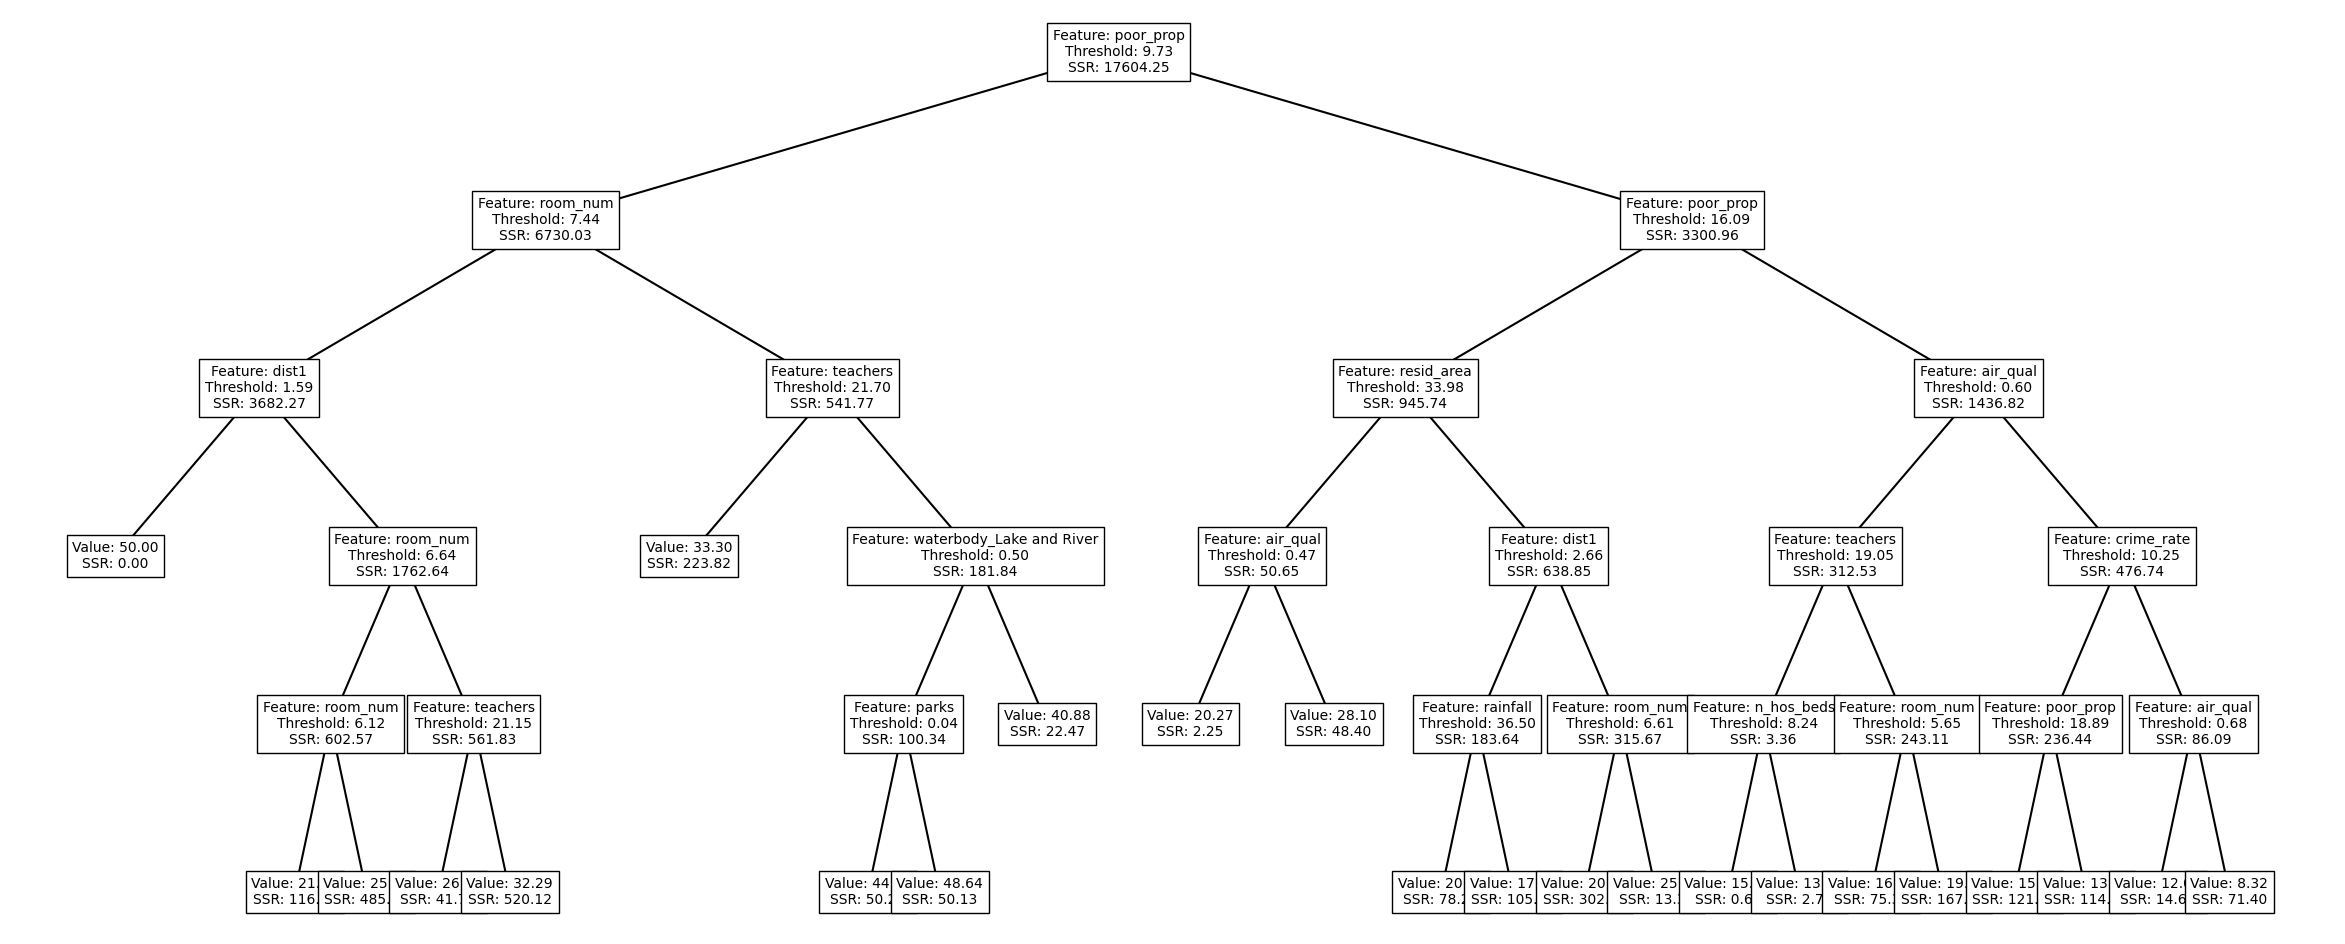

In [8]:
def plot_tree(node, depth=0, ax=None, pos=None, parent_pos=None, node_text=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(30, 12))
        ax.set_axis_off()
        pos = (0.5, 1.0)
        parent_pos = (0.5, 1.0)
        node_text = f'Root\nSSR: {node.ssr:.2f}\nValue: {node.value:.2f}' if node.value is not None else f'Root\nFeature: {X.columns[node.feature_index]}\nThreshold: {node.threshold:.2f}\nSSR: {node.ssr:.2f}'
    
    if node.value is not None:
        ax.text(pos[0], pos[1], f'Value: {node.value:.2f}\nSSR: {node.ssr:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))
    else:
        ax.text(pos[0], pos[1], f'Feature: {X.columns[node.feature_index]}\nThreshold: {node.threshold:.2f}\nSSR: {node.ssr:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))
    
    if parent_pos is not None:
        ax.plot([parent_pos[0], pos[0]], [parent_pos[1], pos[1]], 'k-')
    
    if node.left is not None:
        plot_tree(node.left, depth+1, ax, (pos[0] - 0.5/(2**depth), pos[1] - 0.1), pos, f'Feature: {X.columns[node.feature_index]}\nThreshold: {node.threshold:.2f}')
    
    if node.right is not None:
        plot_tree(node.right, depth+1, ax, (pos[0] + 0.5/(2**depth), pos[1] - 0.1), pos, f'Feature: {X.columns[node.feature_index]}\nThreshold: {node.threshold:.2f}')

# Plot the tree
plot_tree(Tree.root)
plt.show()

For each node:
- Left branch was constructed with a `< threshold` so it means whether `X['feature'] == False` or `X['feature'] < threshold`
- Righ branch means `X['feature'] == True` or `X['feature'] >= threshold`

In [9]:
# Compute the MSE of the tree:
y_pred = Tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

MSE: 13.846155762981956


In [10]:
def cross_validate(model, X, y, k=5):
    fold_size = len(X) // k
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    mse_scores = []
    
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)
    
    return np.mean(mse_scores), np.std(mse_scores)

In [11]:
# Perform cross-validation on my tree
Tree = RegressionTree(min_samples_leaf=3, max_depth=5)
mean_mse, std_mse = cross_validate(Tree, X.values, y.values, k=5)

# Perform cross-validation on sklearn's tree
sklearn_tree = DecisionTreeRegressor(min_samples_leaf=3, max_depth=5)
mse_scores = cross_val_score(sklearn_tree, X.values, y.values, cv=5, scoring="neg_mean_squared_error")
mean_mse_sklearn = -mse_scores.mean()
std_mse_sklearn = mse_scores.std()

C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:57: RuntimeWarning: invalid value encountered in less
  left_indices = np.where(X[:, feature_index] < threshold)
C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:58: RuntimeWarning: invalid value encountered in greater_equal
  right_indices = np.where(X[:, feature_index] >= threshold)
C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:57: RuntimeWarning: invalid value encountered in less
  left_indices = np.where(X[:, feature_index] < threshold)
C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:58: RuntimeWarning: invalid value encountered in greater_equal
  right_indices = np.where(X[:, feature_index] >= threshold)
C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:57: RuntimeWarning: invalid value encountered in less
  left_indices = np.where(X[:, feature_index] < threshold)
C:\Users\doria\AppData\Local\Temp\ipykernel_21876\3066583357.py:58: RuntimeWarning: invalid v

In [12]:
print(f'Mean MSE: {mean_mse}, Std MSE: {std_mse}')
print(f'Sklearn Mean MSE: {mean_mse_sklearn}, Sklearn Std MSE: {std_mse_sklearn}')

Mean MSE: 17.83529908021081, Std MSE: 2.308778736555478
Sklearn Mean MSE: 32.6169354720427, Sklearn Std MSE: 15.639274540109497


My tree perform better than the sklearn tree for same parameters. I don't really know why but this is a good result!

In [128]:
max_depths = np.linspace(5, 50, 7, dtype=int)

mean_mse = []
std_mse = []

for max_depth in tqdm(max_depths):
    # ignore warnings
    warnings.filterwarnings("ignore")
    Tree = RegressionTree(min_samples_leaf=3, max_depth=max_depth)
    mean, std = cross_validate(Tree, X.values, y.values, k=5)
    mean_mse.append(mean)
    std_mse.append(std)

100%|██████████| 7/7 [01:07<00:00,  9.58s/it]


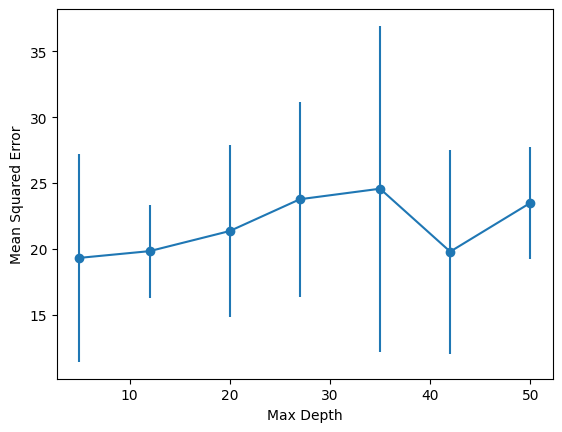

In [130]:
fig, ax = plt.subplots()
ax.errorbar(max_depths, mean_mse, yerr=std_mse, fmt='o-')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean Squared Error')
plt.show()

### Interpretation
We kind of see that the more we allow the tree to go deep, the more fluctuations occurs in MSE, and it increases. This must be due to overfitting the data in the trees.

## Random Forests

In [133]:
class Forest:
    def __init__(self, n_trees=100, n_selected=50, min_samples_leaf=3, max_depth=5):
        self.n_trees = n_trees
        self.n_selected = n_selected
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, y):
        self.trees = [RegressionTree(min_samples_leaf=self.min_samples_leaf, max_depth=self.max_depth) for _ in range(self.n_trees)]
        for tree in tqdm(self.trees):
            X_sample, y_sample = shuffle(X, y, n_samples=len(X))
            tree.fit(X_sample, y_sample)
    
    def predict(self, X):
        return np.mean([tree.predict(X) for tree in shuffle(self.trees, n_samples=self.n_selected)], axis=0)

In [ ]:
# Perform cross-validation on my tree
forest = Forest(n_trees=100, n_selected=50, min_samples_leaf=3, max_depth=5) # 100 trees, 50 selected for each prediction
forest_mean_mse, forest_std_mse = cross_validate(forest, X.values, y.values, k=5)

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


In [142]:
print(f'Single tree MSE: {mean_mse}, Single tree Std MSE: {std_mse}')
print(f'Forest Mean MSE: {forest_mean_mse}, Forest Std MSE: {forest_std_mse}')

Single tree MSE: 22.205346624300642, Single tree Std MSE: 5.465550563350449
Forest Mean MSE: 20.6849857178177, Forest Std MSE: 8.728823073439205


### Interpretation

We notice that the mean MSE computed by 5-fold Cross-Validation of a random forest (size 100 trees, agregation on 50 trees) is slightly lower than the mean MSE of a single tree computed 5-fold Cross-Validation.

However, the Standard Error of Cross-Validation MSE is slightly higher for the random forest compared to a single tree. This confirms the fact that random forests do the bias-variance trade-off by having a MSE that varies a bit more compared to a single tree but in the end, give better MSE most of the cases $\implies$ a more **robust** model.